In [1]:
import psycopg2
import pandas as pd
import numpy as np
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs

from mordred import Calculator, descriptors, Lipinski
import mordred

import constants as co
import data_transformers as dt
from auxiliary import loggers

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, roc_auc_score, recall_score, \
precision_score, accuracy_score, precision_recall_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.decomposition import PCA

from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import BayesianRidge, LinearRegression, LogisticRegression, RidgeClassifier, RidgeClassifierCV

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import pickle
import json

from IPython.display import IFrame

import matplotlib.pyplot as plt
%matplotlib inline

from auxiliary import loggers
import constants as co
import data_transformers as dt
l = loggers.get_logger(logger_name="logger")

pd.set_option('display.max_columns', None)
random_seed = 42

%config Completer.use_jedi = False
l = loggers.get_logger(logger_name="logger")

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import rdBase
from rdkit.Chem import rdMolAlign
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdDistGeom

def confgen(smiles, numConfs=1, maxAttempts=1000, pruneRmsThresh=0.1, useExpTorsionAnglePrefs=True, 
            useBasicKnowledge=True, enforceChirality=True, randomSeed=42):
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles), addCoords=True)
    refmol = Chem.AddHs(Chem.Mol(mol))
    param = rdDistGeom.ETKDGv2()
    
    cids = rdDistGeom.EmbedMultipleConfs(mol, numConfs=numConfs, maxAttempts=maxAttempts, pruneRmsThresh=pruneRmsThresh, 
                                         useExpTorsionAnglePrefs=useExpTorsionAnglePrefs, useBasicKnowledge=useBasicKnowledge,
                                         enforceChirality=enforceChirality, randomSeed=randomSeed)
    
    mp = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94s')
    AllChem.MMFFOptimizeMoleculeConfs(mol, maxIters=512, numThreads=8, mmffVariant='MMFF94s')

    res = [] 
    for cid in cids:
        ff = AllChem.MMFFGetMoleculeForceField(mol, mp, confId=cid)
        e = ff.CalcEnergy()
        res.append((cid, e))
        
    rdMolAlign.AlignMolConformers(mol)
    
    energies = [e for i, e in res]
    
    confs = mol.GetConformers()
    for c, e in zip(confs, energies):
        c.SetProp('Energy', str(e))
    return mol, mp

In [3]:
l.info(os.getcwd())

2022-07-23 08:34:19,495 - logger - INFO - /home/rafalb/work/molecules/moleculeGenerator/moleculegenerator/moleculegenerator/notebooks/activity_prediction/activity_prediction_app_devel/notebook


In [4]:
l.info(os.environ['CONDA_DEFAULT_ENV'])

2022-07-23 08:34:20,170 - logger - INFO - rorgammaqsar


In [5]:
with open(co.TRAINING_CONF_DIR/"mean_no_limits/xgboost_classification_Morgan_1024_pca_128_QED.json", "r") as f:
    training_params = json.load(f)
train_data = dt.data_load(training_params["data_preparation"])

In [6]:
train_data

,canonical_smiles_get_levels,IC50_nM
0,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1,199.530000
1,O=C(O)C(S)C(S)C(=O)O,31900.000000
2,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...,1770.094667
3,CC(C)(c1ccc(O)cc1)c1ccc(O)cc1,10000.000000
4,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CC[C@H](O)C...,2820.000000
...,...,...
2467,O=C(O)Cc1ccc(CNC(=O)Nc2cc(Cl)c(-c3ccccc3OC(F)(...,239.000000
2468,CCS(=O)(=O)c1ccc(CNc2nc3cnc(-c4c(OC)ncnc4C4CC4...,419.000000
2469,CCCS(=O)(=O)c1ccc(CNc2nc3cnc(-c4c(C)ncnc4C4CC4...,44.500000
2470,COc1nc2ccc([C@@](O)(c3ccc(Cl)cc3)c3cncn3C)cc2c...,340.000000


In [7]:
mols = [confgen(item)[0] for item in train_data["canonical_smiles_get_levels"].to_list()[:10]]
calc = mordred.Calculator()
QED_def = dt.get_mordred_descriptors_definition()[0]["QED"]
#calc.register(QED_def[0])
[calc.register(item) for item in QED_def]
calc.pandas(mols)

100%|██████████| 10/10 [00:00<00:00, 274.99it/s]


,SLogP,SMR,naRing,nHBAcc,nHBDon,nRot,MW,TopoPSA
0,5.6026,93.7618,0,1,1,5,300.208930,37.30
1,-0.2476,40.8196,0,4,4,3,181.970751,152.20
2,4.7564,89.4776,2,3,1,5,481.039418,65.99
3,3.4237,68.3416,2,2,2,2,228.115030,40.46
4,7.0895,132.6116,0,2,2,1,456.360345,57.53
5,2.2744,92.8719,2,3,3,5,335.076219,131.73
6,3.7996,79.6993,2,3,2,4,399.036384,74.78
7,3.7502,87.1266,2,3,1,3,425.052034,65.99
8,1.3743,59.8398,2,4,3,1,239.025229,109.00
9,1.9306,61.6654,2,4,2,2,250.029980,82.98


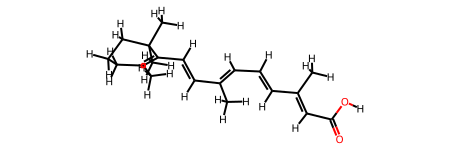

In [8]:
mols[0]

In [9]:
mols = [Chem.MolFromSmiles(item) for item in train_data["canonical_smiles_get_levels"].to_list()[:10]]
calc = mordred.Calculator()
QED_def = dt.get_mordred_descriptors_definition()[0]["QED"]
#calc.register(QED_def[0])
[calc.register(item) for item in QED_def]
calc.pandas(mols)

100%|██████████| 10/10 [00:00<00:00, 406.51it/s]


,SLogP,SMR,naRing,nHBAcc,nHBDon,nRot,MW,TopoPSA
0,5.6026,93.7618,0,1,1,5,300.208930,37.30
1,-0.2476,40.8196,0,4,4,3,181.970751,152.20
2,4.7564,89.4776,2,3,1,5,481.039418,65.99
3,3.4237,68.3416,2,2,2,2,228.115030,40.46
4,7.0895,132.6116,0,2,2,1,456.360345,57.53
5,2.2744,92.8719,2,3,3,5,335.076219,131.73
6,3.7996,79.6993,2,3,2,4,399.036384,74.78
7,3.7502,87.1266,2,3,1,3,425.052034,65.99
8,1.3743,59.8398,2,4,3,1,239.025229,109.00
9,1.9306,61.6654,2,4,2,2,250.029980,82.98


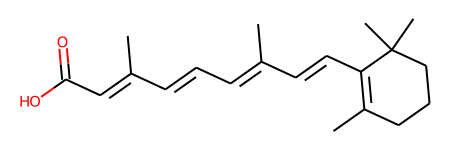

In [10]:
mols[0]

In [21]:
mols = [confgen(item)[0] for item in train_data["canonical_smiles_get_levels"].to_list()[:10]]
fps1 = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024) if x is not None else None for x in mols]
fps1 = [DataStructs.BitVectToText(item) for item in fps1]

In [22]:
mols = [Chem.MolFromSmiles(item) for item in train_data["canonical_smiles_get_levels"].to_list()[:10]]
fps2 = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024) if x is not None else None for x in mols]
fps2 = [DataStructs.BitVectToText(item) for item in fps2]

In [23]:
fps1[0] == fps2[0]

False

In [24]:
fps1[0]

'000001000000000000000000000000000100100000000000000000000000000000000000000000000000000000010000000000000000000000000000100000100000001000000000100000000000000000100000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000010000000000000000000000000100000010000000001000000000000100000100000000000010010001000000000000001000000000000000000000010000000000000000000000000000000000000000001000100000000000001000000000000010000000000000000000000000010000000000000000000000000000000000000000000000000000000000000001000000100000000000000000000000000000000000000000000000000000000000000000000010000010000000100000000000001000000000000000001000000000000000000000001010000000000000000000000010000000000000000000000000000000000000000000000000000000010000000000000000000000000000000100100100000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000001000000000000001000000000001000000011000000010000010000000000000000000000

In [25]:
 fps2[0]

'000010000000000000000000000000010100100000000000000000010000000000000000000000000000000000000000100000000000000000000000000000000000000000100000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000010000000010000100000000000000000000000000000010000000000000000000000000000010000000000000000000000000000001000000000000000000000000000000001000000000000000000000000000000000000000000100000000000100000000000000000000000000000001000000000001000000000001000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000001000000000000000100000000000000000000000100000001000000000000000000000000000000000000000000010001000000000000000100010000000000000000000000000000000000000000000000000000000000000000000000000000000000001000100000000000000000000000000010000000000000000000000000000000000000000000000000000000001000000000000000000000000000000001000001100000000000000000001000000000000000000000010000000000000000000000